In [1]:
# Under Construction
# Denoising and ADMM update in signal domain
# CFHT Dataset

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
import os
from galaxy2galaxy import problems
import tensorflow as tf
from tensorflow.python.eager.context import context, EAGER_MODE, GRAPH_MODE

tf.enable_eager_execution()


%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
tf.executing_eagerly()

True

In [3]:
sigma_noise = 23.59

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # Add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb
    
    sigma_cfht = sigma_noise
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma_cfht, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise

    return dico['inputs'], dico['targets'], dico['psf_cfht']

### Loading Galaxy Images

In [4]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the hsc_problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('attrs2img_cosmos_cfht2hst')
    dset = problem128.dataset(Modes.EVAL, data_dir='UNet_Denoiser/Data/attrs2img_cosmos_cfht2hst/')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 128
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from UNet_Denoiser/Data/attrs2img_cosmos_cfht2hst/attrs2img_cosmos_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


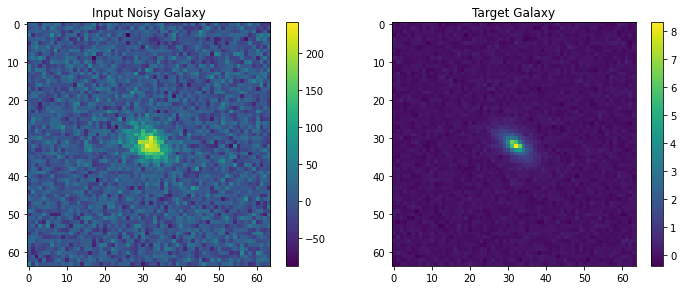

24.211477


In [5]:
ind_val = 73    # Corresponding ground truth & PSF in a batch

gal = np.squeeze(batch[0][ind_val])
gal_target = np.squeeze(batch[1][ind_val])

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(gal)
plt.title("Input Noisy Galaxy")
plt.colorbar(shrink=0.375)

plt.subplot(122)
plt.imshow(gal_target)
plt.title("Target Galaxy")
plt.colorbar(shrink=0.375)

plt.show()

sigma_est = np.std(gal[0:20, 0:20])
print(sigma_est)

### Loading PSF

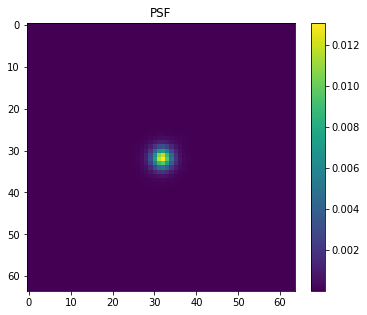

In [6]:
psf = cv.resize(np.abs(np.fft.ifftshift(np.fft.irfft2(np.squeeze(batch[2][ind_val])))), (64,64))
plt.figure(figsize=(6,6))
plt.imshow(psf)
plt.title('PSF')
plt.colorbar(shrink=0.82)
plt.show()

### Load Trained U-Net Model

In [7]:
model = tf.keras.models.load_model('UNet_Denoiser/Models/UNet_basic', compile=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# ADMM in TensorFlow

In [8]:
gal_tf = tf.cast(gal, tf.complex64)
gal_target_tf = tf.cast(gal_target, tf.complex64)
psf_tf = tf.cast(psf, tf.complex64)  

In [9]:
# Utility Functions

def fftconvolve(image, kernel):
   
    x = tf.signal.fftshift(tf.signal.fft2d(image))
    y = tf.signal.fftshift(tf.signal.fft2d(kernel))
    result = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))

    return tf.cast(result, tf.complex64)


def fft(data):

    return ( tf.convert_to_tensor(1.0/data.get_shape().as_list()[0], tf.complex64) * 
             tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(data))) )


def ifft(data):

    return ( tf.convert_to_tensor(data.get_shape().as_list()[0], tf.complex64) *
             tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(data))) )


def nmse(signal_1, signal_2):

    return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)


def max_sv(psf, sigma, rho):
    
    H = tf.signal.fft2d(psf)
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H + rho*sigma**2)
    return tf.cast(tf.math.reduce_max(normH), tf.complex64)

In [10]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(tf.math.real(xi), 0.0), tf.complex64)

 
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, var):

    temp = z - x_rec
    shape = mu.get_shape().as_list()
    
    cost_val = ( tf.cast(0.5, tf.complex64) * rho * tf.norm(temp)**2  -
                 tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                 (tf.cast(0.5, tf.complex64) / var) * tf.norm(y - H(ifft(x_rec), psf))**2 )
     
    return tf.keras.backend.eval(tf.math.real(cost_val)).flatten()


# gradient step size update
def get_alpha(rho, sv, sigma):

    return (tf.cast(1.0, tf.complex64) / 
            ((sv + rho*(sigma**2)) * tf.cast(1.0 + 1.0e-5, tf.complex64)))



def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, disp_step, n_iter):
    
    # Convert arrays to tensors
    
    x_0 = tf.cast(x_0, tf.complex64)
    z_0 = tf.cast(z_0, tf.complex64)
    mu_0 = tf.cast(mu_0, tf.complex64)
    rho_0 = tf.cast(rho_0, tf.complex64)          # Augmented lagrangian hyperparameter
    rho_max = tf.cast(rho_max, tf.complex64)      # max rho value
    eta = tf.cast(eta, tf.complex64)              # should be between - [0, 1)
    gamma = tf.cast(gamma, tf.complex64)          # multiplicative rho factor -- Should be > 1
    
       
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = tf.zeros(tf.shape(y.shape), tf.complex64)
    count = 0
    
    # ADMM parameters
    x_k = x_0
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0                                  # Augmented lagrangian hyperparameter
    delta_k = tf.cast(0.0, tf.complex64)      
 
    # FISTA parameters
    t_k = tf.cast(1.0, tf.complex64)
    z_fista_old = z_0
    sigma = tf.cast(sigma_noise, tf.complex64)
    
    
    # square of spectral radius of convolution matrix
    sv = max_sv(psf, sigma, rho_k)         
    

    # The gradient descent step
    alpha = get_alpha(rho_k, sv, sigma)
    
    
    # TEST - Denoise before ADMM
    #"""
    fig = plt.subplots(1,2, figsize=(10,10))
    
    plt.subplot(121)
    plt.title('Input')
    plt.imshow(np.real(tf.keras.backend.eval(y)))
    
    y = tf.expand_dims(tf.expand_dims(y, axis=0), axis=-1)
    y = tf.cast(tf.squeeze(model(tf.math.abs(y))), tf.complex64)
    
    plt.subplot(122)
    plt.title('Denoised')
    plt.imshow(np.real(tf.keras.backend.eval(y)))
    #"""
        
        
        
    for k in range(n_iter):
        
        ## FISTA update
        
        x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf)  + 
                                      mu_k * sigma**2  + 
                                      rho_k * sigma**2 * (z_fista_old - z_k)) 
        
        x_k1 = proj(x_k1)
        
        t_k1 = ( (tf.cast(1.0, tf.complex64) + 
                  tf.math.sqrt(tf.cast(4.0, tf.complex64)*t_k**2 + tf.cast(1.0, tf.complex64))) 
                / tf.cast(2.0, tf.complex64) )
        
        lambda_fista = tf.cast(1.0, tf.complex64) + (t_k -  tf.cast(1.0, tf.complex64)) / t_k1
        
        z_fista_new = x_k + lambda_fista * (x_k1 - x_k)
        
        z_fista_old = z_fista_new
        t_k = t_k1
        
           
    
        ## Denoising sub-step
        
        z_k1 = x_k1 + mu_k/rho_k
        
        # Estimate sigma for z_k1
        sigma_est = np.std(tf.keras.backend.get_value(z_k1)[0:10, 0:10])
        
        # Hard thresholding
        #tp = tf.keras.backend.get_value(z_k1)
        #tp[np.real(tp) <= 6*sigma_est] = 0
        #z_k1 = tf.cast(tp, tf.complex64)
        
        # Denoising
        #z_k1 = tf.expand_dims(tf.expand_dims(z_k1, axis=0), axis=-1)
        #z_k1 = tf.cast(tf.squeeze(model(tf.math.abs(z_k1))), tf.complex64)
        
        

        ## mu update
        mu_k1 = mu_k + (x_k1 - z_k1) * rho_k
    
        
        ## Cost
        cost.append(cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2))
        
        
        ## Rho & alpha update       

        test1 = (tf.math.abs(gamma * rho_k) < tf.math.abs(rho_max))

        delta_k1 = tf.cond(test1, lambda: (tf.cast(1.0/gal_tf.get_shape().as_list()[0], tf.complex64) * 
                                           (tf.norm(x_k1 - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k))), 
                                  lambda: delta_k)
                
        test2 = (test1 and (tf.math.abs(delta_k1) > tf.math.abs(eta * delta_k)))
        
        rho_k1 = tf.cond(test2, lambda: gamma * rho_k, lambda: rho_k)
        alpha = tf.cond(test2, lambda: get_alpha(rho_k1, sv, 1.0), lambda: alpha)

        
        
        
        # Update all variables
        delta_k = tf.cond(test1, lambda: delta_k1, lambda: delta_k)
        rho_k = rho_k1
        x_k = x_k1
        mu_k = mu_k1
        z_k = z_k1
        sv = max_sv(psf, sigma, rho_k)
        
            
    
        final_im = tf.math.abs(x_k)

        nmse_arr[k] = nmse(gal_tf, tf.cast(final_im, tf.complex64))
        
        
        
        if nmse_arr[k]==np.min(nmse_arr):
            x_opt = final_im
        
        
        
        if k%disp_step==0 and k!=0:
            
            print(sigma_est)
            
            fig = plt.subplots(1,3, figsize=(25,25))
            
            plt.subplot(131)
            plt.title('Reconstruction after {} iterations'.format(k))
            ax1 = plt.gca()
            rec = tf.keras.backend.get_value(final_im)
            im1 = ax1.imshow(rec)
            divider = make_axes_locatable(ax1)
            cax1 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im1, cax=cax1)

            plt.subplot(132)
            plt.title('Target')
            ax2 = plt.gca()
            im2 = ax2.imshow(gal_target)
            divider = make_axes_locatable(ax2)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im2, cax=cax2)

            plt.subplot(133)
            plt.title('Intensity Plot (Central Slice)')
            ax3 = plt.gca()
            ax3.plot(tf.keras.backend.get_value(final_im)[y.get_shape().as_list()[0]//2,:], label='rec_im')           
            ax3.plot(gal_target[y.get_shape().as_list()[0]//2,:], label='target')  
            plt.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio())
            
            plt.show(fig)
                 
    return final_im, x_opt, cost, nmse_arr

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.03519286


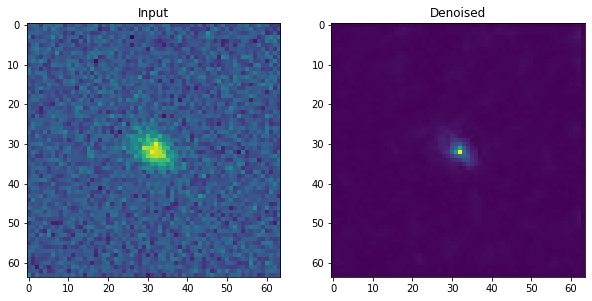

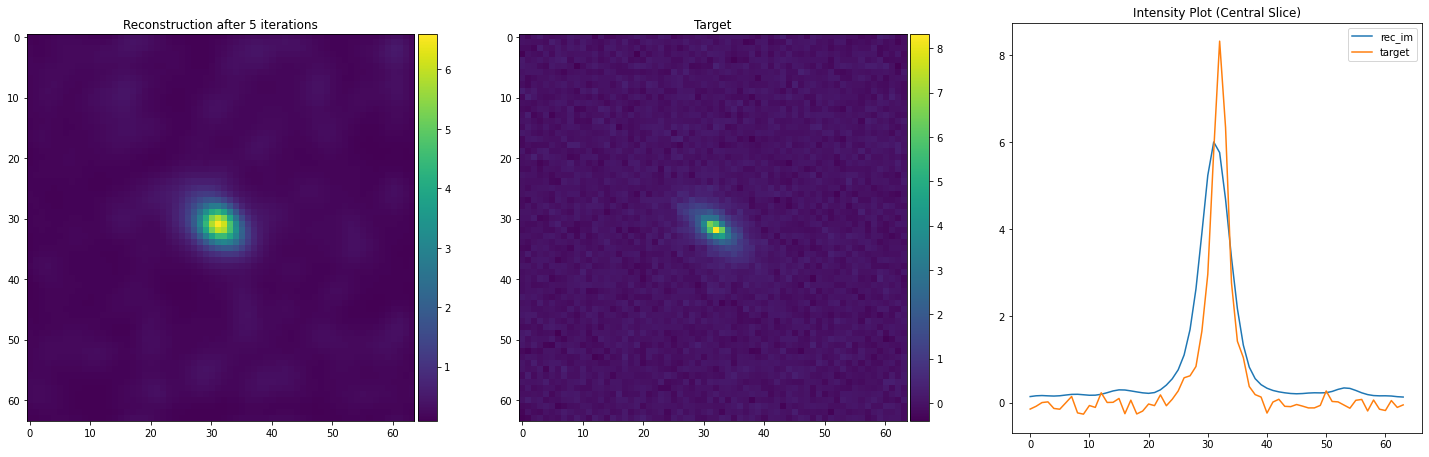

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.039851636


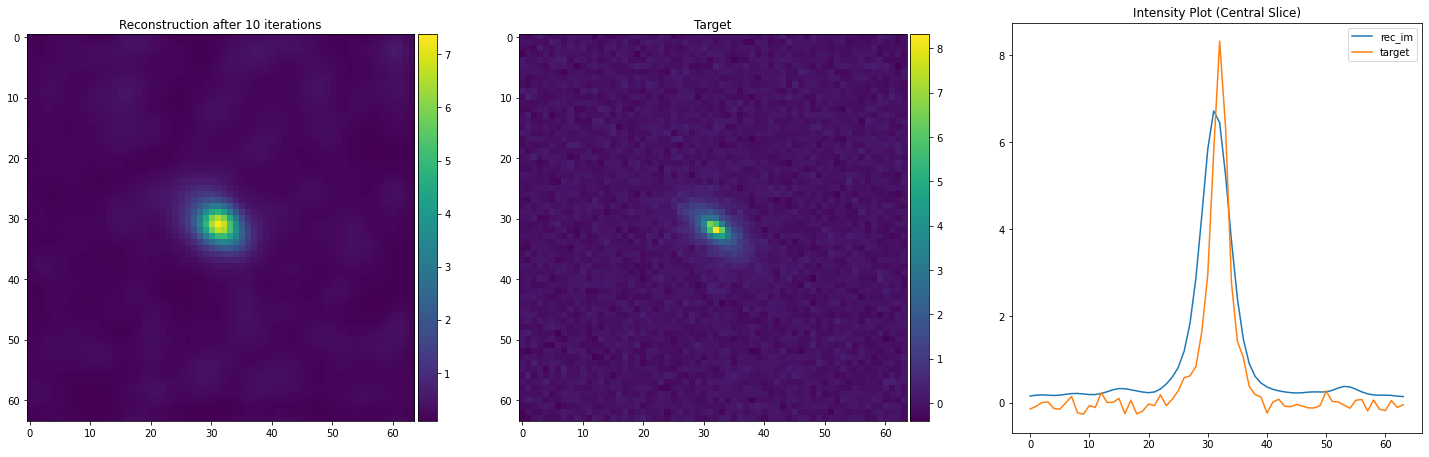

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.04068074


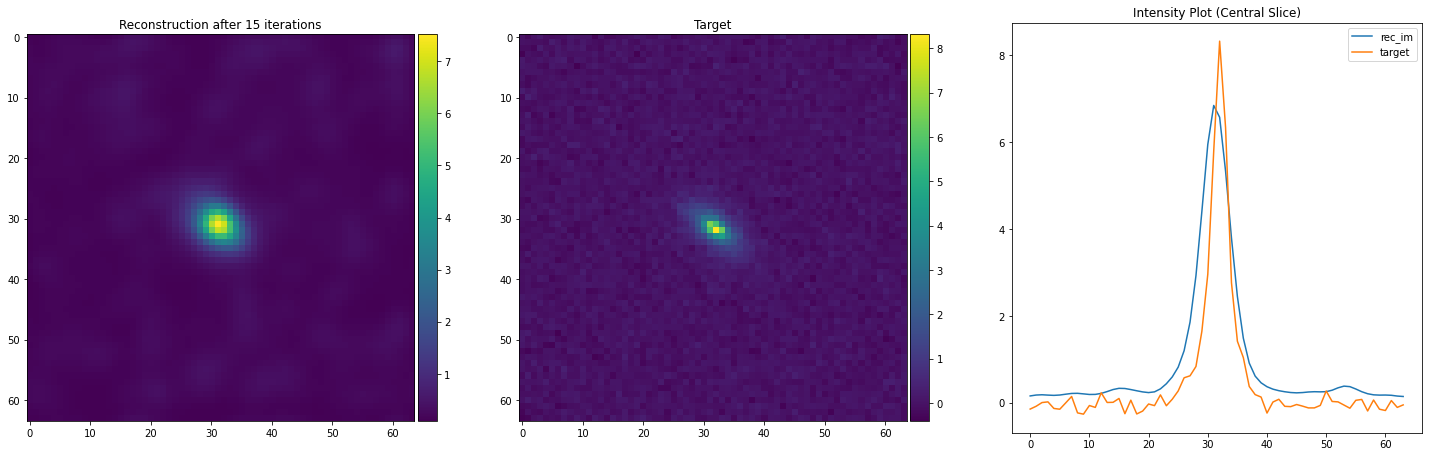

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.0408319


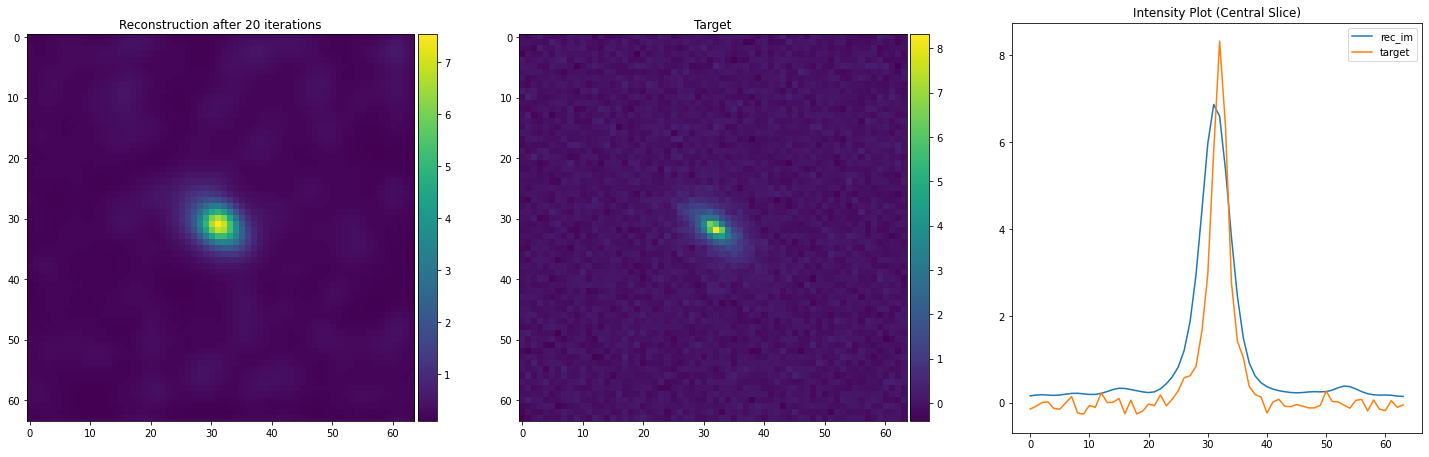

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040859696


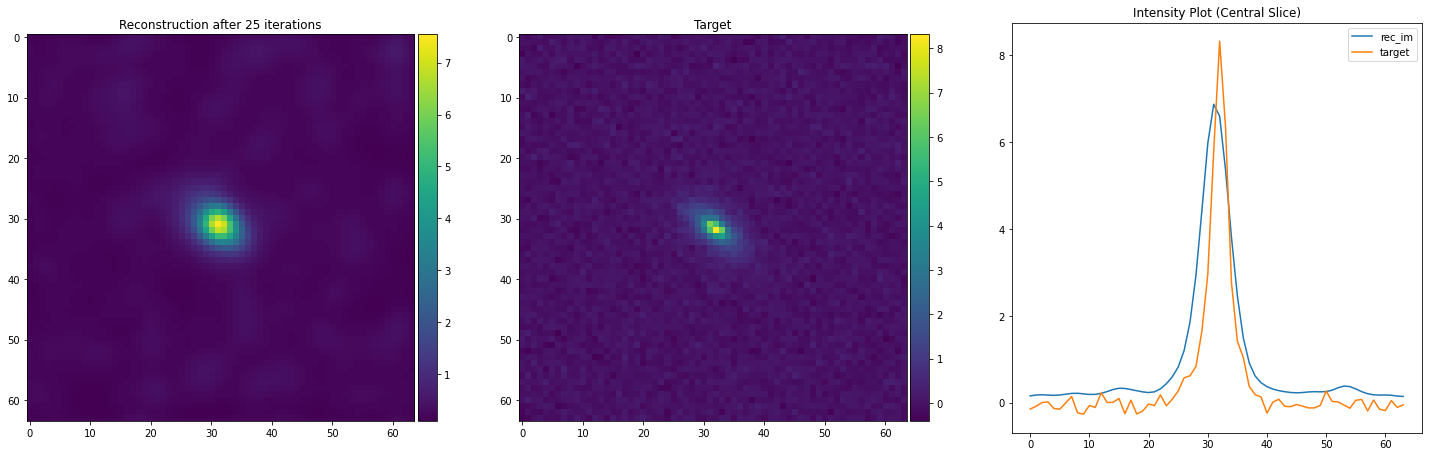

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040864825


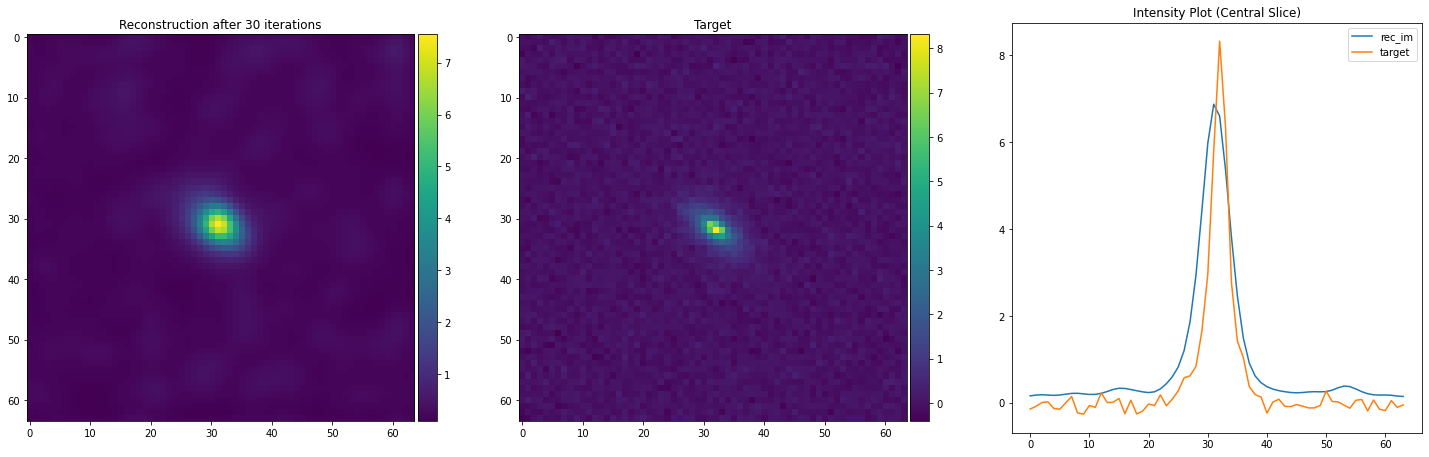

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.04086577


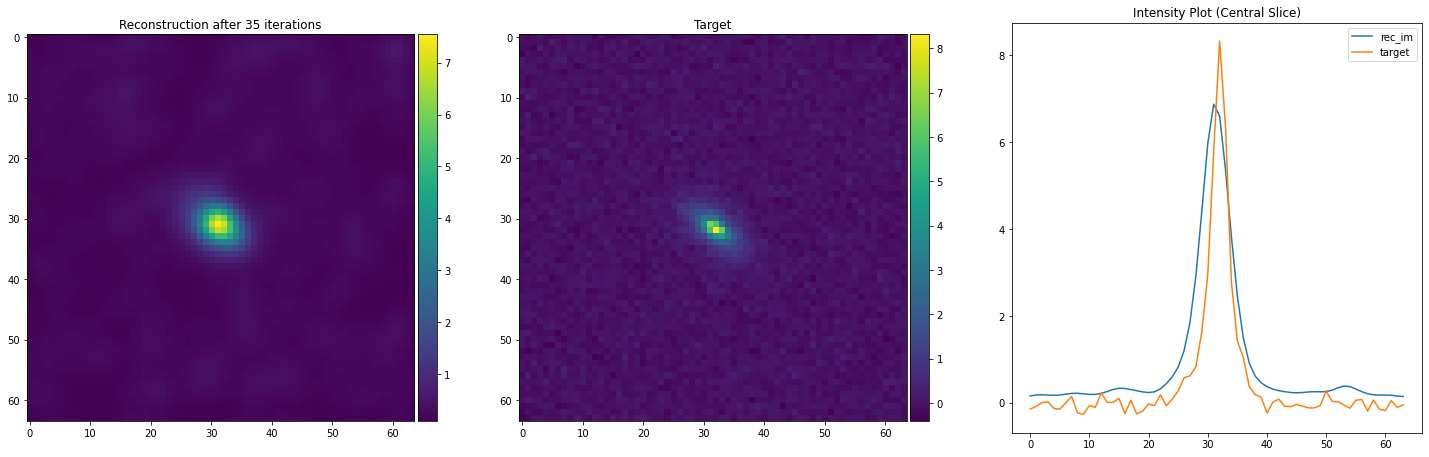

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.04086595


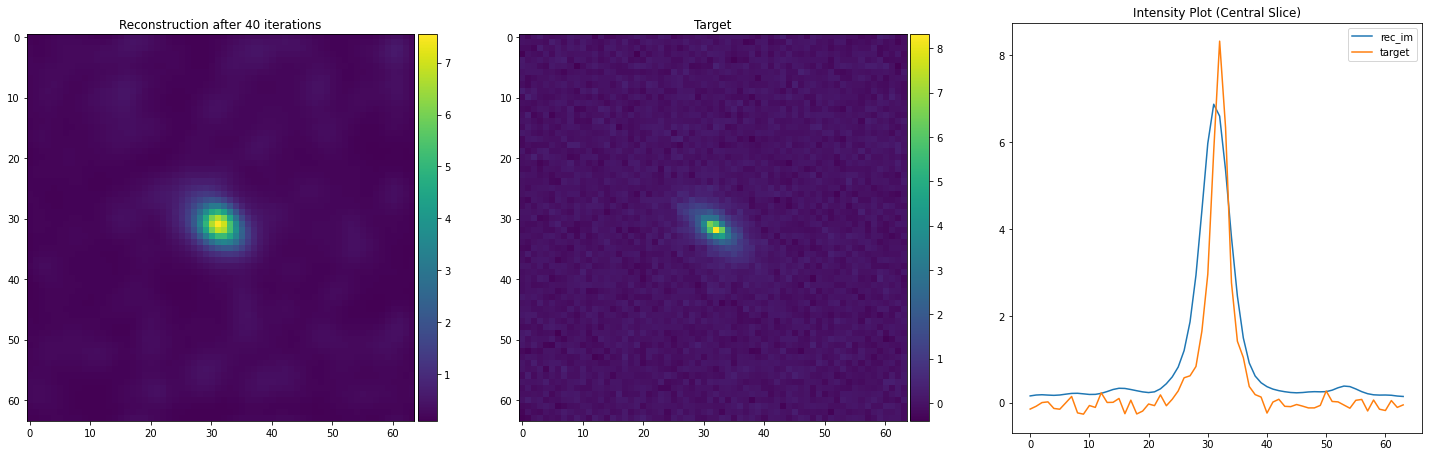

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865976


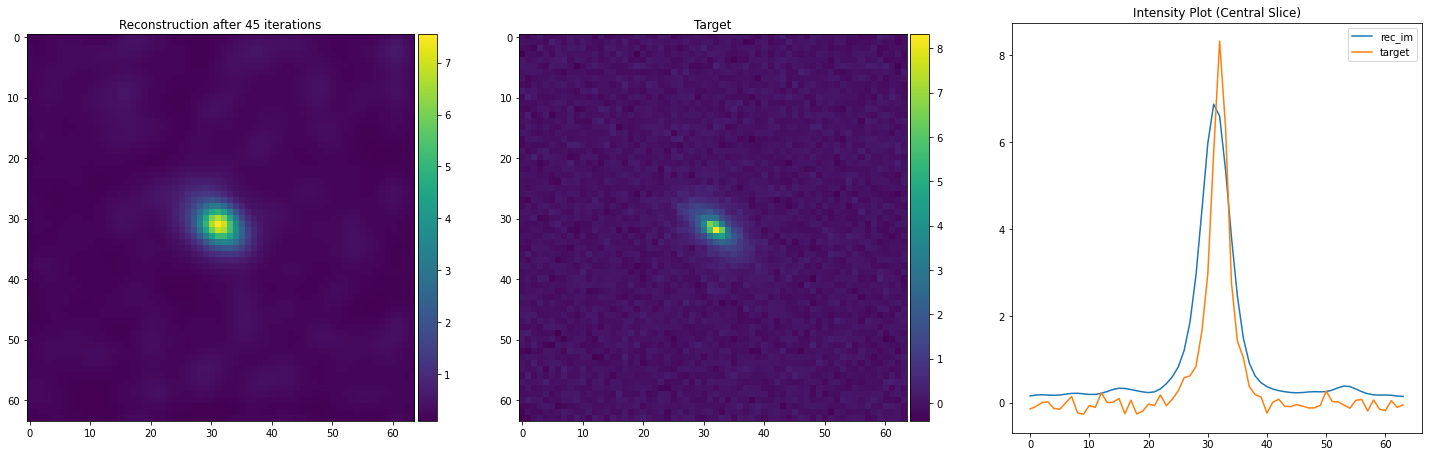

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


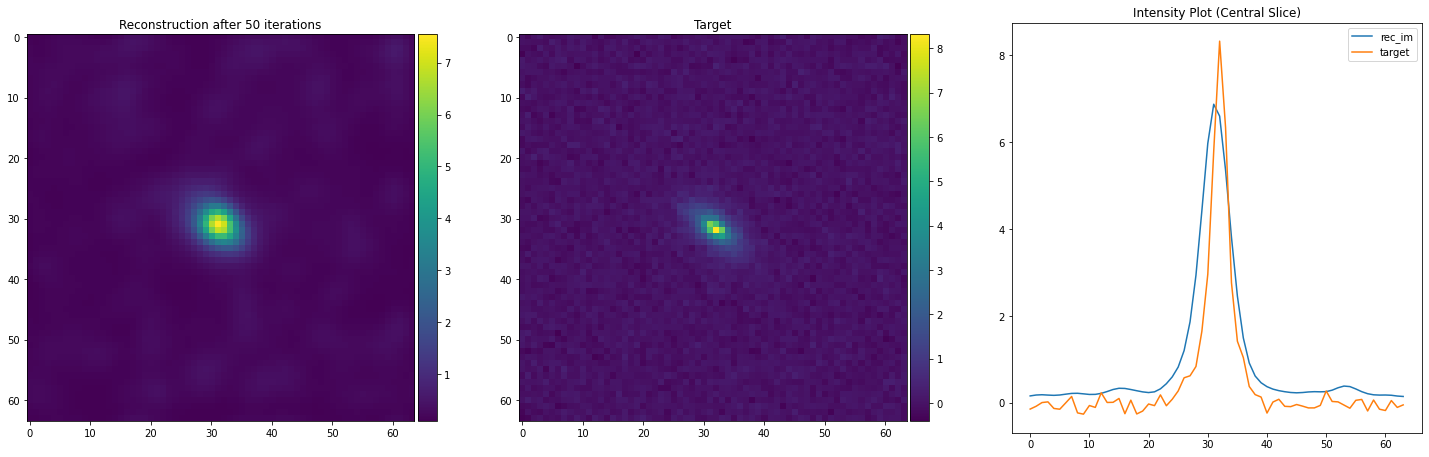

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


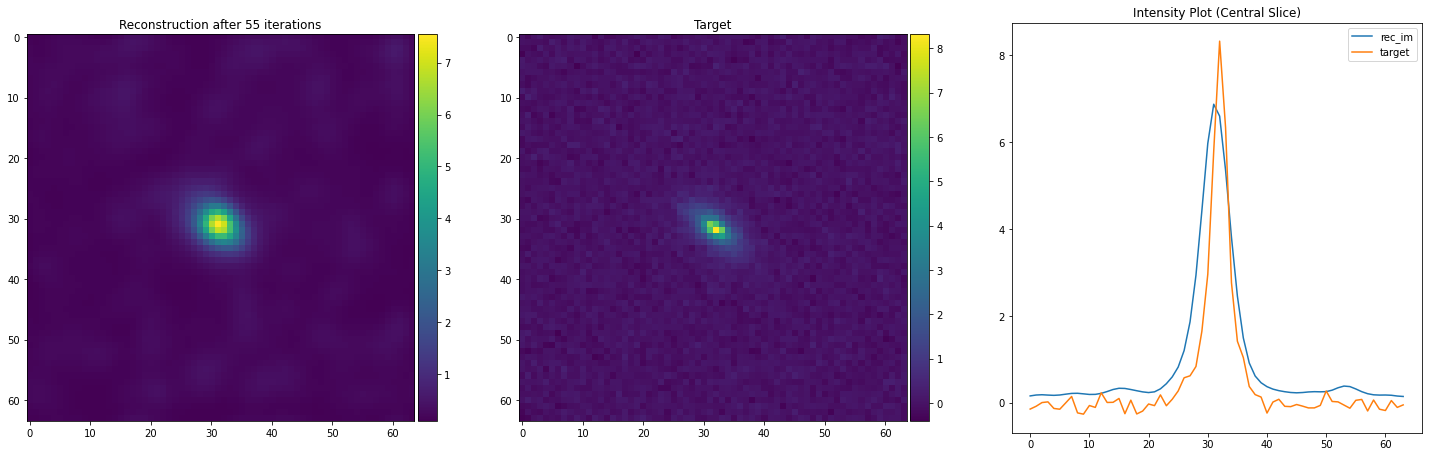

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


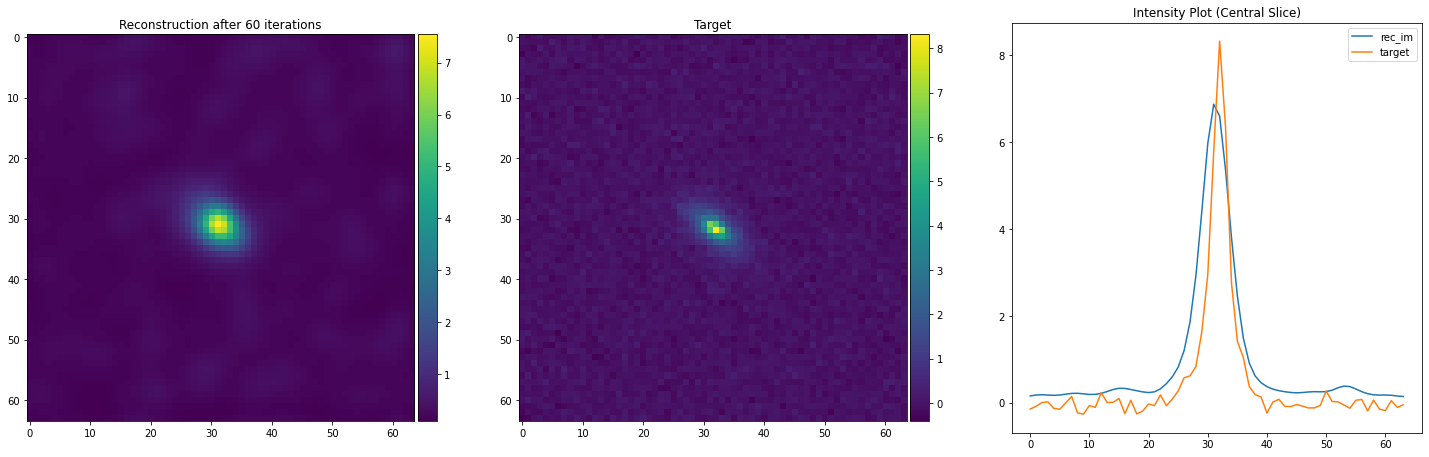

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


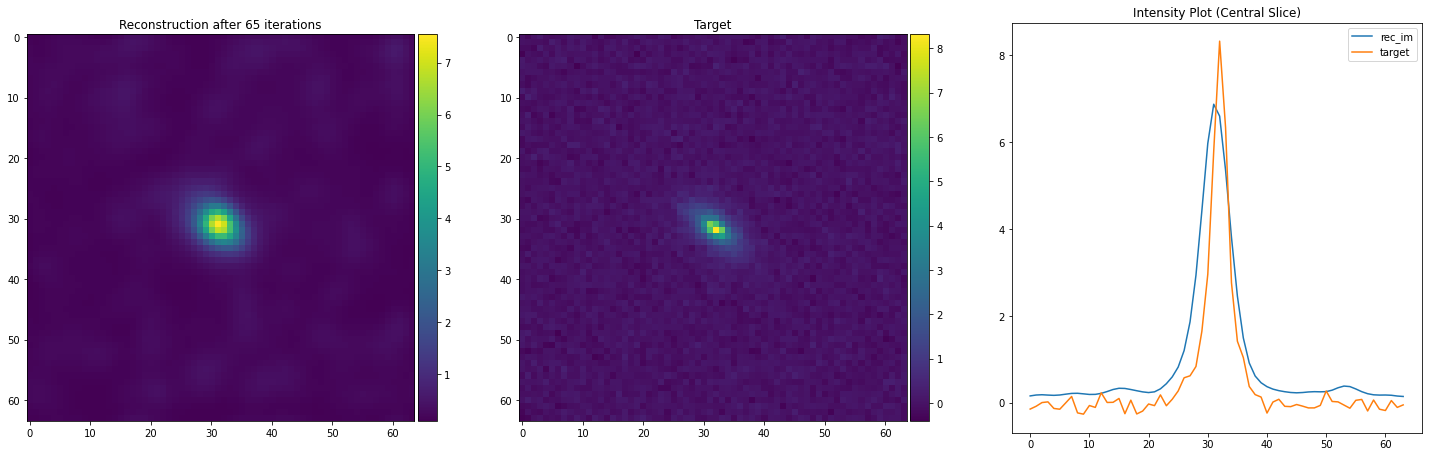

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


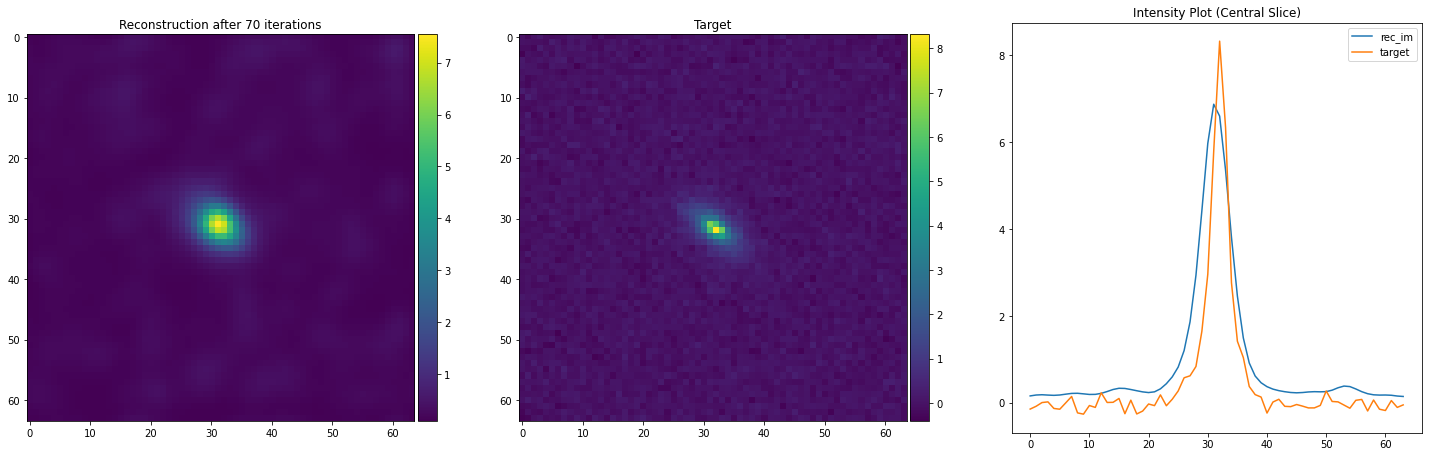

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


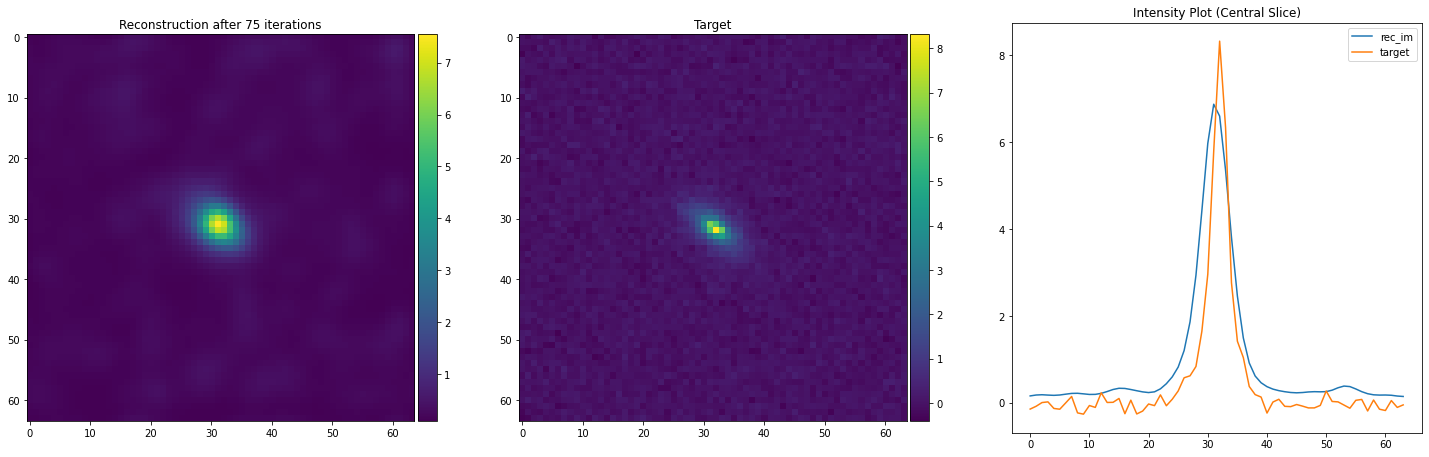

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


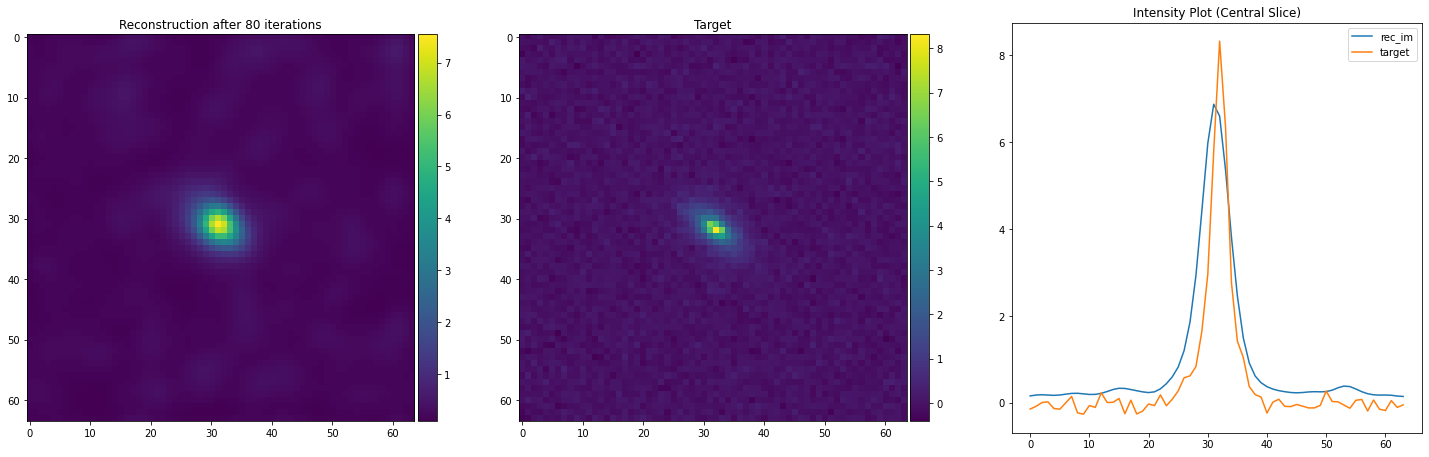

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


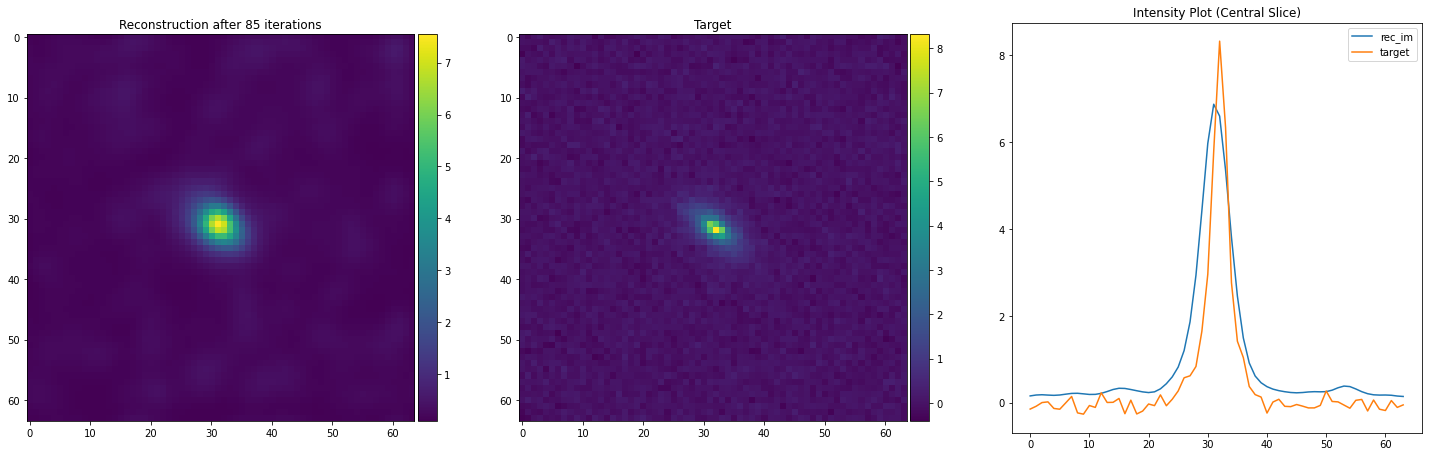

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


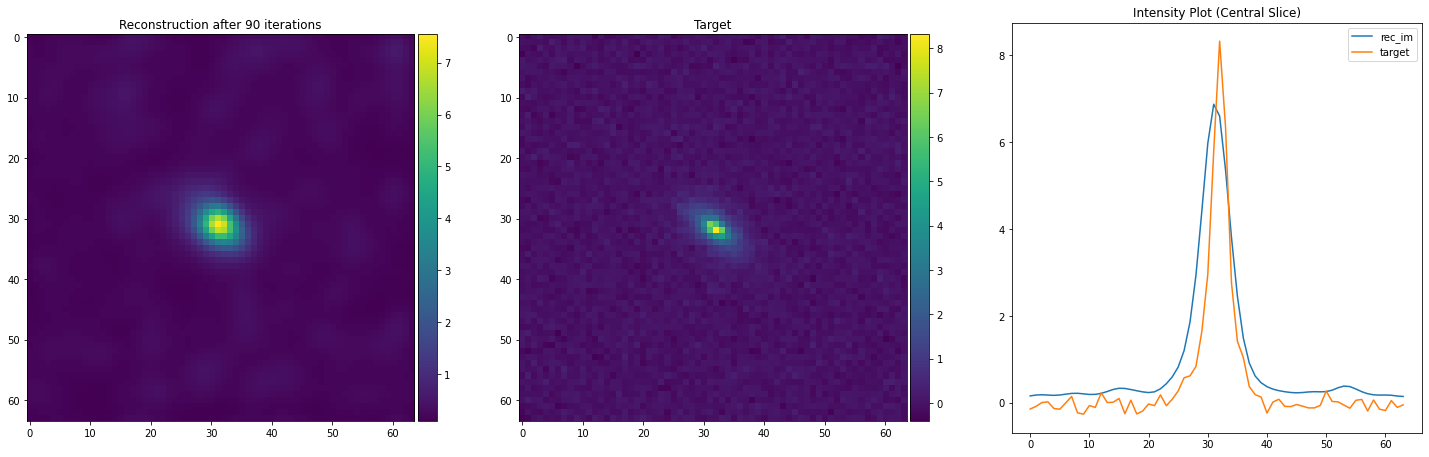

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


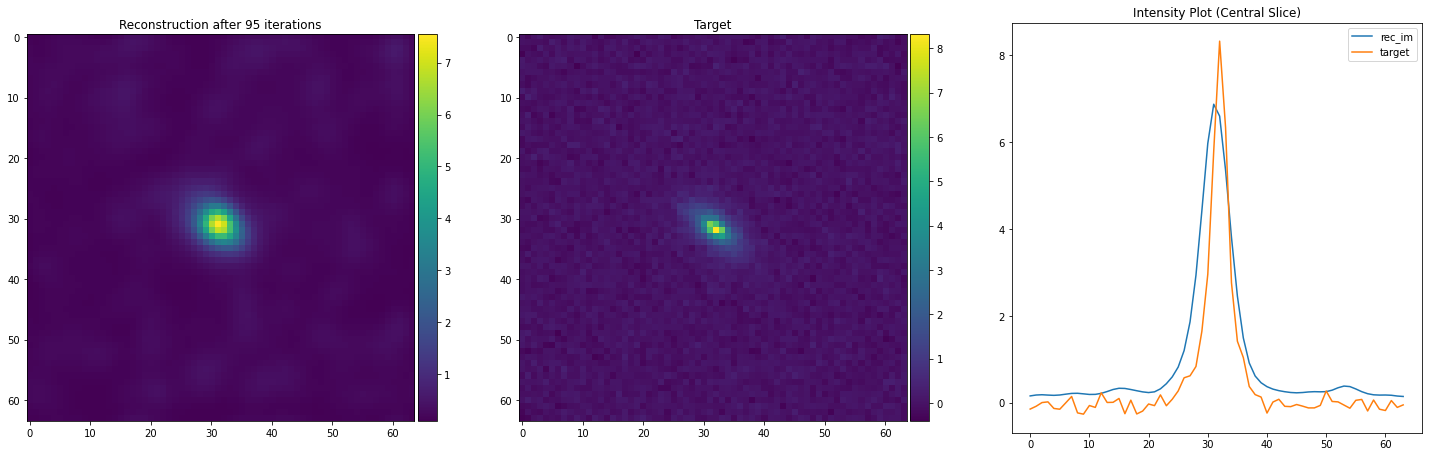

/local/home/ua264756/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:180: ComplexWarning: Casting complex values to real discards the imaginary part


0.040865984


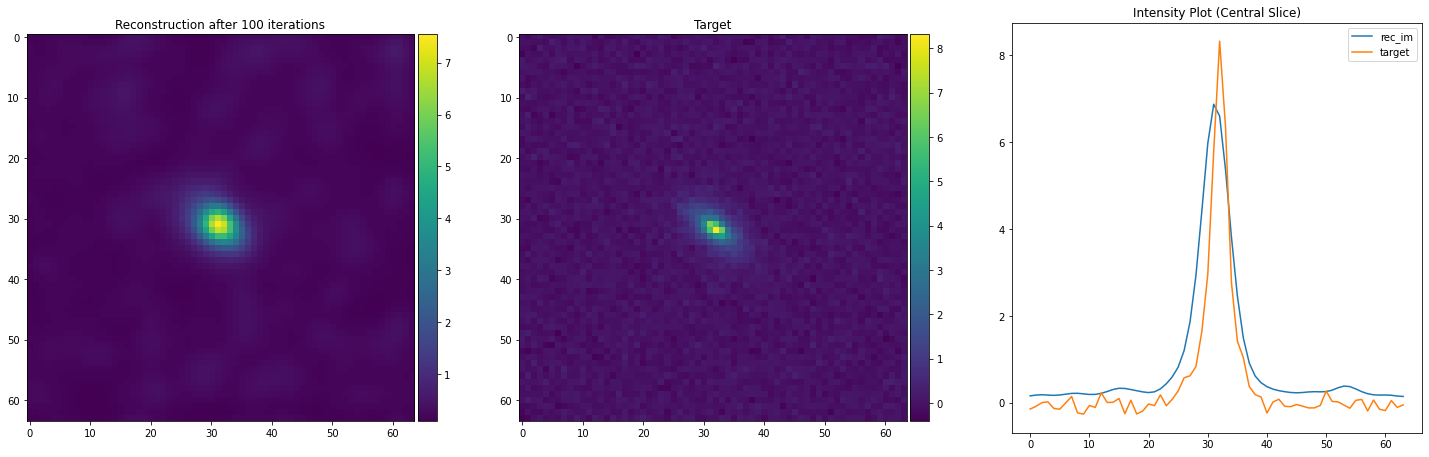

In [11]:
n_iter = 101
disp_step = 5

# ADMM parameters (initial)
x_0 = np.zeros(gal.shape)
z_0 = np.zeros(gal.shape)
mu_0 = 0.0
#rho_0 = 3.5e-2                                   # Augmented lagrangian hyperparameter
#rho_0 = 5e-5                             # Denoise after fista
rho_0 = 5e-4                              # Denoise before fista
rho_max = 1.0e5                                  # max rho value
eta = 0.5                                        # should be between - [0, 1)
gamma = 1.4                                      # multiplicative rho factor -- Should be > 1

# Deconvolve the image
final_im, x_opt, cost, nmse_arr = runADMM(gal_tf, x_0, psf_tf, grad, z_0, mu_0, rho_0, 
                                          rho_max, eta, gamma, disp_step, n_iter)

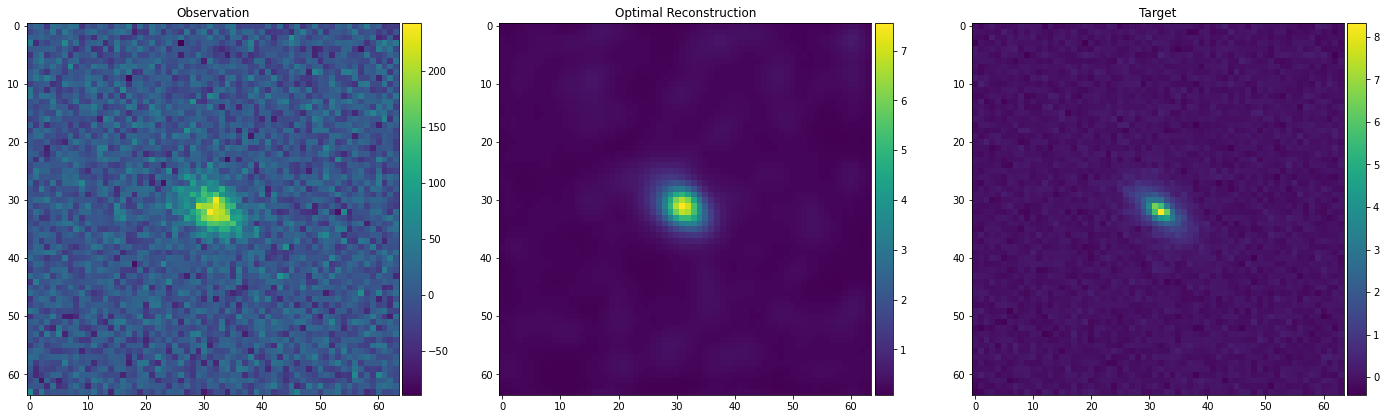

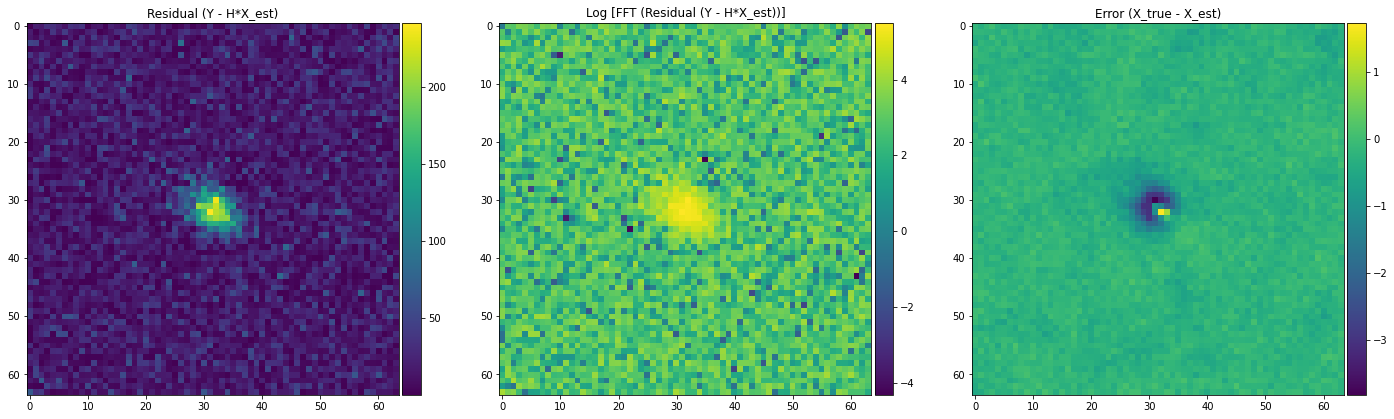

In [12]:
# Comparison

fig = plt.subplots(1,3, figsize=(24,24))

plt.subplot(131)
plt.title('Observation')
ax1 = plt.gca()
im1 = ax1.imshow(gal)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

plt.subplot(132)
plt.title('Optimal Reconstruction')
ax2 = plt.gca()
im2 = ax2.imshow(tf.keras.backend.get_value(x_opt))
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.subplot(133)
plt.title('Target')
ax3 = plt.gca()
im3 = ax3.imshow(np.real(gal_target))
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

plt.show(fig)


fig2 = plt.subplots(1,3, figsize=(24,24))
plt.subplot(131)
plt.title('Residual (Y - H*X_est)')
ax1 = plt.gca()
residual = tf.math.abs(gal_tf - fftconvolve(psf_tf, tf.cast(x_opt, tf.complex64)))
im1 = ax1.imshow(tf.keras.backend.get_value(residual))
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

plt.subplot(132)
plt.title('Log [FFT (Residual (Y - H*X_est))]')
ax2 = plt.gca()
im2 = ax2.imshow(tf.keras.backend.get_value(tf.math.log(residual)))
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.subplot(133)
plt.title('Error (X_true - X_est)')
ax3 = plt.gca()
im3 = ax3.imshow(tf.keras.backend.get_value(tf.math.real(gal_target_tf) - x_opt))
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

plt.show(fig2)

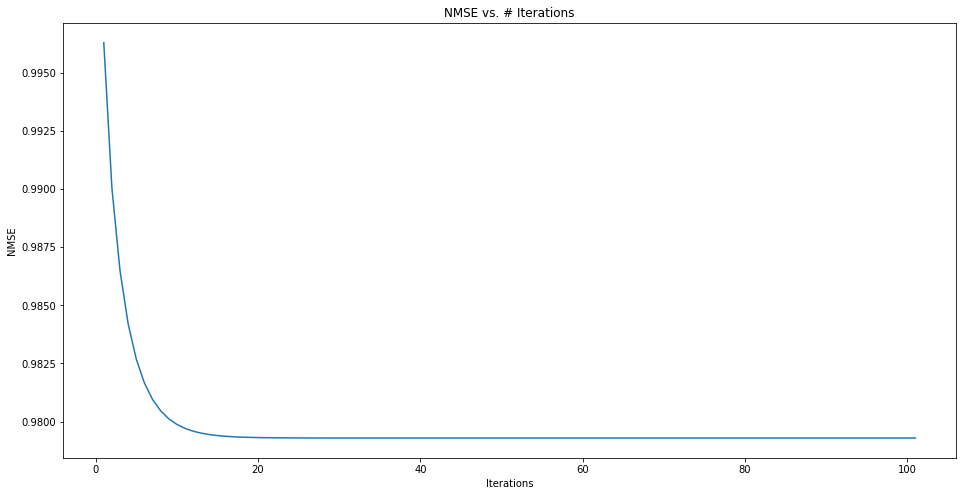


Minimum NMSE = 0.9792937636375427 (at [ 36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100] iterations)


In [13]:
min_nmse = np.min(nmse_arr)
min_iter_nmse = np.where(nmse_arr == min_nmse)[0]

plt.figure(figsize=(16,8))
plt.plot(np.arange(1,n_iter+1), nmse_arr)
plt.title('NMSE vs. # Iterations')
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show()
print('\nMinimum NMSE = {} (at {} iterations)'.format(min_nmse, min_iter_nmse))

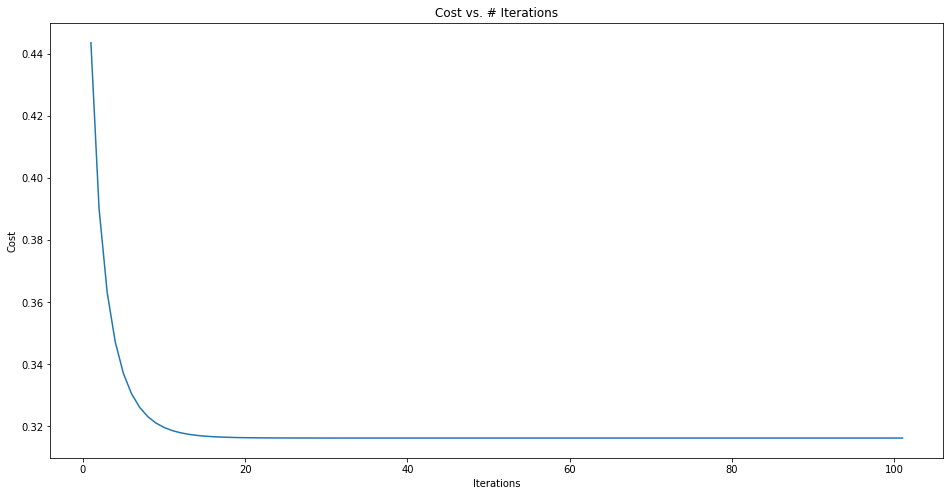


Minimum Cost = 0.3162258565425873 (at [ 39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100] iterations)


In [14]:
cost_arr = np.real(cost)
min_cost = np.min(cost_arr)
min_iter_cost = np.where(cost_arr == min_cost)[0]

plt.figure(figsize=(16,8))
plt.plot(np.arange(1,n_iter+1), cost_arr)
plt.title('Cost vs. # Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()
print('\nMinimum Cost = {} (at {} iterations)'.format(min_cost, min_iter_cost))

### Simple Denoising (U-Net without ADMM)

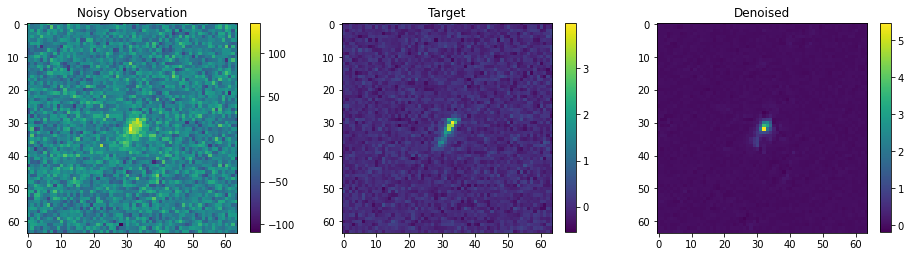

In [15]:
test_ind = 3

gal_denoise = tf.expand_dims(tf.expand_dims(np.squeeze(batch[0][test_ind]), axis=0), axis=-1)
gal_denoise = tf.squeeze(model(tf.cast(gal_denoise, tf.float32)))

plt.figure(figsize=(16,16))
plt.subplot(131)
plt.title('Noisy Observation')
plt.imshow(np.squeeze(batch[0][test_ind]))   
plt.colorbar(shrink=0.24)
plt.subplot(132)
plt.title('Target')
plt.imshow(np.squeeze(batch[1][test_ind]))
plt.colorbar(shrink=0.24) 
plt.subplot(133)
plt.title('Denoised')
plt.imshow(gal_denoise)
plt.colorbar(shrink=0.24)
plt.show()